<a href="https://colab.research.google.com/github/cutaya004/AI-RiskInvest/blob/main/AI_RiskInvest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
# 1) Importer les librairies
# =========================
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt

In [46]:
# 2) Nettoyage + conversion date + tri
# ============================================================
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"]).copy()
df = df.sort_values("date").reset_index(drop=True)

# S'assurer que les colonnes numériques sont bien numériques
num_cols = ["open", "high", "low", "close", "volume", "change_percent", "avg_vol_20d"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Supprimer les lignes avec valeurs manquantes importantes
df = df.dropna(subset=["open", "high", "low", "close", "volume"]).copy()
df = df.reset_index(drop=True)

print("✅ Après nettoyage :", df.shape)


✅ Après nettoyage : (10864, 21)


In [47]:
# 3) Création du Target (Label)
# ============================================================
# Target = 1 si le prix de demain (close) > prix d'aujourd'hui (close)
PRICE_COL = "close"
df["target"] = (df[PRICE_COL].shift(-1) > df[PRICE_COL]).astype(int)

# Supprimer la dernière ligne (pas de "demain")
df = df.iloc[:-1].copy().reset_index(drop=True)


In [48]:
# 4) Feature Engineering (simple, pas de modèle bizarre)
# ============================================================
# Rendement (return) du jour
df["ret_1"] = df[PRICE_COL].pct_change()

# Retards (lags) : utiliser l'information passée (sans fuite)
df["ret_2"] = df["ret_1"].shift(1)
df["ret_3"] = df["ret_1"].shift(2)

# Moyennes mobiles (tendance)
df["ma_5"]  = df[PRICE_COL].rolling(5).mean()
df["ma_10"] = df[PRICE_COL].rolling(10).mean()
df["ma_20"] = df[PRICE_COL].rolling(20).mean()

# Écart au-dessus de la moyenne (normalisé)
df["dist_ma_5"]  = (df[PRICE_COL] - df["ma_5"]) / df["ma_5"]
df["dist_ma_10"] = (df[PRICE_COL] - df["ma_10"]) / df["ma_10"]
df["dist_ma_20"] = (df[PRICE_COL] - df["ma_20"]) / df["ma_20"]

# Volatilité (risque) sur 10 jours
df["vol_10"] = df["ret_1"].rolling(10).std()

# Informations de la bougie (candlestick)
df["range_hl"] = (df["high"] - df["low"]) / df["open"]
df["gap_oc"]   = (df["close"] - df["open"]) / df["open"]

# Volume (log pour réduire les grosses valeurs)
df["log_volume"] = np.log1p(df["volume"])

# Nettoyer les NaN créés par rolling/shift
df = df.dropna().reset_index(drop=True)

print("✅ Après features :", df.shape)


✅ Après features : (10844, 21)


In [49]:
# 5) Définir X / y + split temporel (80% train / 20% test)
# ============================================================
features = [
    "ret_1", "ret_2", "ret_3",
    "dist_ma_5", "dist_ma_10", "dist_ma_20",
    "vol_10", "range_hl", "gap_oc",
    "log_volume"
]

# Si tu veux garder change_percent et avg_vol_20d (optionnel) :
if "change_percent" in df.columns:
    features.append("change_percent")
if "avg_vol_20d" in df.columns:
    features.append("avg_vol_20d")

X = df[features]
y = df["target"]

split = int(len(df) * 0.8)

X_train = X.iloc[:split]
X_test  = X.iloc[split:]
y_train = y.iloc[:split]
y_test  = y.iloc[split:]

print("✅ Train:", X_train.shape, "| Test:", X_test.shape)


✅ Train: (8675, 10) | Test: (2169, 10)


In [50]:
# 6) Normalisation (StandardScaler)
# ============================================================
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

In [51]:
# 7) Entraîner le modèle (Régression Logistique)
# ============================================================
model = LogisticRegression(max_iter=2000, random_state=42)
model.fit(X_train_sc, y_train)

pred = model.predict(X_test_sc)

print("\n✅ Accuracy :", accuracy_score(y_test, pred))
print("\n✅ Matrice de confusion :\n", confusion_matrix(y_test, pred))
print("\n✅ Rapport de classification :\n", classification_report(y_test, pred))




✅ Accuracy : 0.48363301060396496

✅ Matrice de confusion :
 [[ 957   70]
 [1050   92]]

✅ Rapport de classification :
               precision    recall  f1-score   support

           0       0.48      0.93      0.63      1027
           1       0.57      0.08      0.14      1142

    accuracy                           0.48      2169
   macro avg       0.52      0.51      0.39      2169
weighted avg       0.52      0.48      0.37      2169



In [52]:
# 8) Backtest simple (cohérent avec close)
# ============================================================
df_test = df.iloc[split:].copy().reset_index(drop=True)

# Rendement du lendemain (close)
df_test["daily_return"] = df_test[PRICE_COL].pct_change().shift(-1)

# Supprimer la dernière ligne (pas de lendemain)
df_test = df_test.iloc[:-1].copy().reset_index(drop=True)

# Adapter la longueur des prédictions
pred_bt = pred[:len(df_test)]
df_test["signal"] = pred_bt

# Rendement stratégie
df_test["strategy_return"] = df_test["signal"] * df_test["daily_return"]

# Performance cumulée
df_test["cum_market"]   = (1 + df_test["daily_return"]).cumprod()
df_test["cum_strategy"] = (1 + df_test["strategy_return"]).cumprod()

print("\n✅ Résultat final backtest :")
print("Marché (Buy & Hold) :", df_test["cum_market"].iloc[-1])
print("Stratégie (Modèle)  :", df_test["cum_strategy"].iloc[-1])



✅ Résultat final backtest :
Marché (Buy & Hold) : 6.495083863504882
Stratégie (Modèle)  : 1.4336345176929437


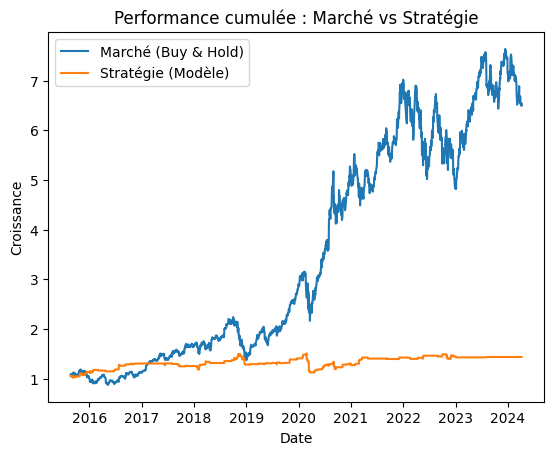

In [53]:
# 9) Visualisation
# ============================================================
plt.figure()
plt.plot(df_test["date"], df_test["cum_market"], label="Marché (Buy & Hold)")
plt.plot(df_test["date"], df_test["cum_strategy"], label="Stratégie (Modèle)")
plt.title("Performance cumulée : Marché vs Stratégie")
plt.xlabel("Date")
plt.ylabel("Croissance")
plt.legend()
plt.show()